# Hemoglobinopathies_train_test_XGBoost_Logistic_Regression 

<a name='1'></a>
# 1 - Setup and Imports

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf

import tempfile, urllib, zipfile
from  sklearn import experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve)
import xgboost as xgb
from tqdm.notebook import tqdm

import pickle
import pandoc
import shap
import util
from scipy import stats

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
xgb.__version__

'1.7.3'

<a name='2'></a>
# 2 - Load the Dataset

<a name='2-1'></a>
## 2.1 Read and Split the Dataset

In [220]:
# Read xlsx data into a dataframe and recognize the missing data that is encoded with '?' string as NaN
df_affected = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/03_Thalassemie/03_Analyse/10_All_Labs/01_Data/07SEP2023_All_labs_testaffected.xlsx')
df_gal = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/03_Thalassemie/02_Data/Galdakao/Revised/28AUG2023 - Allindices final_para_Urko - All Data.xlsx')
df_jbz = pd.read_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/03_Thalassemie/03_Analyse/10_All_Labs/01_Data/03AUG2023 Additionele interne validatie JBZ.xlsx')

df_affected.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [221]:
df_gal_feat = df_gal[['Mean_Corpuscular_Volume', 'Red_Blood_Cell_Distribution_Width', 'Mean_Corpuscular_Hemoglobin',
                      'Hemoglobin','Mean_Corpuscular_Hemoglobin_Concentration', 'Erytrocytes', 'Trombocytes', 'Diagnosis',
                      'affected_model', 'alpha_model', 'beta_model']]

<a name='2-2'></a>
## 2.2 Clean up data, select features, check for null values

In [260]:
#drop all rows where more 5 out of 8 features is missing
df_affected_missingness = df_affected.dropna(axis=0, how='any', thresh=5, subset=['Mean_Corpuscular_Volume', 'Red_Blood_Cell_Distribution_Width', 'Mean_Corpuscular_Hemoglobin', 
                    'Ferritin','Hemoglobin', 'Mean_Corpuscular_Hemoglobin_Concentration', 'Erytrocytes', 'Trombocytes'])

#df_affected_missingness.info()

In [223]:
# Features of interest
ALL_KEYS = ['Hemoglobin', 'Mean_Corpuscular_Volume', 'Mean_Corpuscular_Hemoglobin', 'Erytrocytes', 'Reticulocytes', 'Trombocytes', 'Leukocytes', 'Ferritin', 'Hemoglobin_in_Reticulocytes', 'Sex', 'GenTest']


FEATURE_KEYS_test = ['Mean_Corpuscular_Volume', 'Red_Blood_Cell_Distribution_Width', 'Mean_Corpuscular_Hemoglobin', 
                     'Hemoglobin', 'Mean_Corpuscular_Hemoglobin_Concentration',
                    'Erytrocytes', 'Trombocytes']

FEATURE_KEYS_test_Y = ['Mean_Corpuscular_Volume', 'Red_Blood_Cell_Distribution_Width', 'Mean_Corpuscular_Hemoglobin', 
                     'Hemoglobin', 'Mean_Corpuscular_Hemoglobin_Concentration', 
                    'Erytrocytes', 'Trombocytes', 'affected_model']

In [8]:
percent_missing = df_affected_missingness.groupby('Lab')[FEATURE_KEYS_test].apply(lambda x: x.notnull().sum()/len(x)*100)
percent_missing.to_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/03_Thalassemie/03_Analyse/10_All_Labs/02_Analyses/28JUN2023_Missingness_model.xlsx') 

## 2.3. Create datasets for model assessment alpha, beta, sickle and combinations.  

In [9]:
df_alpha = df_affected_missingness[df_affected_missingness['alpha_model'].notnull()]
df_beta = df_affected_missingness[df_affected_missingness['beta_model'].notnull()]
df_comb = df_affected_missingness[df_affected_missingness['combinations_model'].notnull()]
df_sikkel = df_affected_missingness[df_affected_missingness['hbs_model'] == 'Sikkelcelziekte']

In [10]:
df_alpha_wo_med = df_alpha[df_alpha['Lab'] != 'Medlon']

#df_affected_wo_med = df_affected_missingness[(df_affected_missingness['Lab'] != 'Isala') & (df_affected_missingness['Lab'] != 'Medlon')]

df_alpha_med = df_alpha[df_alpha['Lab'] == 'Medlon'].sample(frac=1, random_state=38)
df_alpha_med_mis = df_alpha_med.dropna(axis=0, how='any', thresh=7, subset=['Mean_Corpuscular_Volume', 'Red_Blood_Cell_Distribution_Width', 'Mean_Corpuscular_Hemoglobin', 
                    'Hemoglobin', 'Mean_Corpuscular_Hemoglobin_Concentration', 'Erytrocytes', 'Trombocytes'])


## 2.3 Exclude Medlon as external validation set and collect only complete cases

### 2.3.1 Medlon

In [228]:
df_affected_wo_med = df_affected_missingness[df_affected_missingness['Lab'] != 'Medlon'].sample(frac=1, random_state=38)
df_affected_med = df_affected_missingness[df_affected_missingness['Lab'] == 'Medlon'].sample(frac=1, random_state=38)

In [229]:
#Apply one-hot encoding to sex and binary class
compute_dummy = {'Sex': {'M': 0, "V": 1}, 
                'affected_model': {'Negative': 0, 'Affected': 1}
                }       
df_affected_med.replace(compute_dummy, inplace=True) #df_affected_med
df_affected_med = df_affected_med[FEATURE_KEYS_test_Y].dropna() #drop all null values
med_test = df_affected_med[FEATURE_KEYS_test]
med_test_label = df_affected_med['affected_model']

In [230]:
len(med_test_label)

2656

In [231]:
med_test_label.value_counts()

0    1652
1    1004
Name: affected_model, dtype: int64

In [15]:
df_affected_wo_med['affected_model'].value_counts()

Affected    3249
Negative    2659
Name: affected_model, dtype: int64

### 2.3.2 Jeroen Bosch Hospital (semi-prospective Internal Validation)

In [16]:
#Apply one-hot encoding to sex and binary class
compute_dummy = {'Sex': {'M': 0, "V": 1}, 
                'affected_model': {'Negatief': 0, 'Affected': 1}
                }       
df_jbz.replace(compute_dummy, inplace=True) 

df_jbz_2 = df_jbz[FEATURE_KEYS_test_Y].dropna()

jbz_test = df_jbz_2[FEATURE_KEYS_test]
jbz_test_label = df_jbz_2['affected_model']

In [17]:
jbz_test_label.value_counts()

0    191
1     71
Name: affected_model, dtype: int64

### 2.3.3 Galdakao


In [20]:
#define inputs and target
df_gal_feat_alpha = df_gal_feat[df_gal_feat['alpha_model'].notnull()]
df_gal_feat_beta = df_gal_feat[df_gal_feat['beta_model'].notnull()]
df_gal_feat = df_gal_feat[df_gal_feat['affected_model'].notnull()]

gal_test = df_gal_feat[FEATURE_KEYS_test]
gal_test_label = df_gal_feat['affected_model']

In [21]:
#impute the missing platelets using iterative imputer
imputer = IterativeImputer(max_iter=100, random_state=38)
imputer.fit(gal_test)
gal_test_imp = imputer.transform(gal_test)
columns=['Mean_Corpuscular_Volume','Red_Blood_Cell_Distribution_Width','Mean_Corpuscular_Hemoglobin', 'Hemoglobin','Mean_Corpuscular_Hemoglobin_Concentration', 'Erytrocytes','Trombocytes']
gal_test_imp = pd.DataFrame(gal_test_imp.reshape(len(gal_test_imp), -1),columns=columns)

In [22]:
gal_test_label.value_counts()

1.0    1370
0.0    1259
Name: affected_model, dtype: int64

In [23]:
gal_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean_Corpuscular_Volume,2629.0,71.438825,5.909166,52.600000,66.700000,71.900000,76.700000,88.500000
Red_Blood_Cell_Distribution_Width,2629.0,16.486459,4.941008,2.966782,14.900000,16.400000,18.400000,42.100000
Mean_Corpuscular_Hemoglobin,2629.0,1.416921,0.136301,0.887601,1.309677,1.421403,1.520715,2.343800
Hemoglobin,2629.0,7.141751,1.100275,2.792700,6.454240,7.198960,7.819560,16.133862
Mean_Corpuscular_Hemoglobin_Concentration,2629.0,19.821443,0.844274,12.148643,19.480141,19.849461,20.206279,37.079375
Erytrocytes,2629.0,5.081618,0.881565,1.790000,4.450000,5.090000,5.700000,8.590030
Trombocytes,797.0,279.051916,95.302280,10.400000,218.554000,270.381000,320.900000,901.000000


In [24]:
gal_test_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean_Corpuscular_Volume,2629.0,71.438825,5.909166,52.600000,66.700000,71.900000,76.700000,88.500000
Red_Blood_Cell_Distribution_Width,2629.0,16.486459,4.941008,2.966782,14.900000,16.400000,18.400000,42.100000
Mean_Corpuscular_Hemoglobin,2629.0,1.416921,0.136301,0.887601,1.309677,1.421403,1.520715,2.343800
Hemoglobin,2629.0,7.141751,1.100275,2.792700,6.454240,7.198960,7.819560,16.133862
Mean_Corpuscular_Hemoglobin_Concentration,2629.0,19.821443,0.844274,12.148643,19.480141,19.849461,20.206279,37.079375
Erytrocytes,2629.0,5.081618,0.881565,1.790000,4.450000,5.090000,5.700000,8.590030
Trombocytes,2629.0,292.387403,59.631384,10.400000,264.306950,293.969350,321.220984,901.000000


## 2.4 Create Cross Validation Dataset 

In [232]:
#Shuffle model development dataset (without Medlon)
df = df_affected_wo_med.sample(frac=1, random_state=138)

#Apply one-hot encoding to sex and binary class
compute_dummy = {'Sex': {'M': 0, "V": 1}, 
                'affected_model': {'Negative': 0, 'Affected': 1}
                }       
df.replace(compute_dummy, inplace=True)
#df.info()

### 2.4.1 IMPUTATION (optional for XGB, required for LR) & 10-Fold Cross Validation

In [233]:
#define our features and the label and split the data:
y = df['affected_model'] #1768 (Neg=1594, Beta=247)
X = df[FEATURE_KEYS_test]

#impute the data
imputer = IterativeImputer(max_iter=10, random_state=38)
imputer.fit(X)
Xtrans = imputer.transform(X)
# the model learns that the second feature is double the first
columns=['Mean_Corpuscular_Volume','Red_Blood_Cell_Distribution_Width','Mean_Corpuscular_Hemoglobin', 'Hemoglobin','Mean_Corpuscular_Hemoglobin_Concentration', 'Erytrocytes','Trombocytes']

Xtrans = pd.DataFrame(Xtrans.reshape(len(Xtrans), -1),columns=columns)
#convert to data format XGBoost supports for ingestion
#data_dmatrix = xgb.DMatrix(data=Xtrans,label=y)

#Stratified split of the data to preserve (potential) class imbalance:
X_train, X_test, y_train, y_test = train_test_split(Xtrans, y, test_size=0.2, random_state=138, stratify=y) # 70/30 train-test set

#We can now get the folds using our train set. I use a repeated k-fold to get more score results :
cv    = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=138)
folds = [(train,test) for train, test in cv.split(X_train, y_train)] 

In [27]:
Xtrans.to_excel('C:/Users/anoes/OneDrive/Documents/Aanstelling RadboudUMC/03_Thalassemie/03_Analyse/10_All_Labs/02_Analyses/27JUL2023_Xtrans.xlsx')

In [27]:
#Verify distributions with and without imputation
Xtrans.describe().T
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean_Corpuscular_Volume,5797.0,78.454701,10.479868,48.00,71.00,78.40,86.000,129.0
Red_Blood_Cell_Distribution_Width,4535.0,15.424807,2.924596,11.00,13.30,14.70,16.700,34.3
Mean_Corpuscular_Hemoglobin,4106.0,1.550392,0.258625,0.76,1.35,1.55,1.742,3.6
Hemoglobin,5906.0,7.294819,1.370634,2.40,6.30,7.30,8.200,12.6
Mean_Corpuscular_Hemoglobin_Concentration,4819.0,19.930650,1.146524,14.00,19.20,20.00,20.700,29.7
Erytrocytes,5875.0,4.733627,0.925868,1.49,4.10,4.70,5.340,8.3
Trombocytes,4871.0,280.755286,103.099249,9.00,220.00,267.00,322.000,1977.0


### 2.4.1.1 Imputation split out per laboratory (internal validation)

In [89]:
lab = df['Lab'].reset_index(drop=True)
Xtrans_lab = Xtrans
Xtrans_lab['Lab'] = lab
Xtrans_lab['affected_model'] = df['affected_model'].reset_index(drop=True)
Xtrans_mea = Xtrans_lab[Xtrans_lab['Lab'] == 'Meander'].sample(frac=1, random_state=38)
Xtrans_max = Xtrans_lab[Xtrans_lab['Lab'] == 'Maxima'].sample(frac=1, random_state=38)
Xtrans_isa = Xtrans_lab[Xtrans_lab['Lab'] == 'Isala'].sample(frac=1, random_state=38)
Xtrans_zuy = Xtrans_lab[Xtrans_lab['Lab'] == 'Zuyderland'].sample(frac=1, random_state=38)
Xtrans_amp = Xtrans_lab[Xtrans_lab['Lab'] == 'Amphia'].sample(frac=1, random_state=38)

### 2.4.2 NO IMPUTATION (Optional)

In [90]:
#define our features and the label and split the data:
y = df['affected_model'] #1768 (Neg=1594, Beta=247)
X = df[FEATURE_KEYS_test]

#convert to data format XGBoost supports for ingestion
data_dmatrix = xgb.DMatrix(data=X,label=y)

#Stratified split of the data to preserve (potential) class imbalance:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y) # 70/30 train-test set

#We can now get the folds using our train set. I use a repeated k-fold to get more score results :
cv    = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=138)
folds = [(train,test) for train, test in cv.split(X_train, y_train)] # 70/30 train-test set per fold

### 2.4.3 Internal validation: Split the test set per lab

In [48]:
df_affected_wo_med['Lab'].value_counts()

Amphia        1486
Isala         1223
JBZ            909
Maastad        779
Zuyderland     716
Maxima         681
Meander        114
Name: Lab, dtype: int64

In [58]:
#Isala without imputation
df_affected_isa = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Isala']
test_set_isa = df_affected_isa.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_isa.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_isa.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
isa_test = test_set_isa[FEATURE_KEYS_test]
isa_test_label = test_set_isa['affected_model']


In [59]:
#Isala with imputation
df_affected_isa = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Isala']
test_set_isa = Xtrans_isa.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_isa.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_isa.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
isa_test = test_set_isa[FEATURE_KEYS_test]
isa_test_label = test_set_isa['affected_model']

In [60]:
test_set_isa['affected_model'].value_counts()

0    140
1     90
Name: affected_model, dtype: int64

In [50]:
#Zuyderland without imputation
df_affected_zuy = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Zuyderland']
test_set_zuy = df_affected_zuy.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_zuy.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_zuy.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
zuy_test = test_set_zuy[FEATURE_KEYS_test]
zuy_test_label = test_set_zuy['affected_model']

In [51]:
#Zuyderland with imputation
df_affected_zuy = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Zuyderland']
test_set_zuy = Xtrans_zuy.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_zuy.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_zuy.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
zuy_test = test_set_zuy[FEATURE_KEYS_test]
zuy_test_label = test_set_zuy['affected_model']

In [57]:
test_set_zuy['affected_model'].value_counts()

0    81
1    69
Name: affected_model, dtype: int64

In [52]:
#Amphia without imputation
df_affected_amp = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Amphia']
test_set_amp = df_affected_amp.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_amp.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_amp.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
amp_test = test_set_amp[FEATURE_KEYS_test]
amp_test_label = test_set_amp['affected_model']

In [53]:
#Amphia with imputation
df_affected_amp = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Amphia']
test_set_amp = Xtrans_amp.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_amp.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_amp.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
amp_test = test_set_amp[FEATURE_KEYS_test]
amp_test_label = test_set_amp['affected_model']

In [56]:
test_set_amp['affected_model'].value_counts()

0    217
1     91
Name: affected_model, dtype: int64

In [54]:
#Maxima without imputation
df_affected_max = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Maxima']
test_set_max = df_affected_max.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_max.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_max.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
max_test = test_set_max[FEATURE_KEYS_test]
max_test_label = test_set_max['affected_model']

In [55]:
#Maxima with imputation
df_affected_max = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Maxima']
test_set_max = Xtrans_max.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_max.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_max.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
max_test = test_set_max[FEATURE_KEYS_test]
max_test_label = test_set_max['affected_model']

In [162]:
test_set_max['affected_model'].value_counts()

0    72
1    50
Name: affected_model, dtype: int64

In [61]:
#Meander without imputation
df_affected_mea = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Meander']
test_set_mea = df_affected_mea.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_mea.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_mea.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
mea_test = test_set_mea[FEATURE_KEYS_test]
mea_test_label = test_set_mea['affected_model']

In [62]:
#Meander with imputation
df_affected_mea = df_affected_wo_med[df_affected_wo_med['Lab'] == 'Meander']
test_set_mea = Xtrans_mea.merge(X_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set_mea.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set_mea.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)
mea_test = test_set_mea[FEATURE_KEYS_test]
mea_test_label = test_set_mea['affected_model']

In [63]:
test_set_mea['affected_model'].value_counts()

1    18
0    11
Name: affected_model, dtype: int64

<a name='3'></a>
## 3 -  Model Building

<a name='3-1'></a>
### 3.1 Baseline Model: XGBoost 

Few notes: 
- **Class Imbalance**: In the case of class imbalance (such as for specfic subclasses), is possible to scale the gradient for the loss function for the positive class differently (scale_pos_weight = total_negative_examples / total_positive_examples) this can help the model achieve better performance when making predictions on the positive class. 
- **Strong and weak features**: Based on meeting experts, I assume that some features (MCV) have strong signals and others weak. Therefore, I will set a lower learning rate and early stopping the eleviate this. Early stopping prevents overfitting.

In [234]:
#Cost-Sensitive XGBoost for class imbalance 
counter = Counter(y)
# Estimate scale_pos_weight value, with class labels are 0 (not affected) and 1 (affected).
#weight = counter[0] / counter[1]

#Dictionary to collect results in:
metrics = ['auc', 'fpr', 'tpr', 'avgp', 'precision', 'recall', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

#To initialise XGBoost we have to chose some parameters:
params = {
    'eta'         : '0.1', #lower learning rate
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss',
} 

#Run our cross validation and save all scores to our dictionary
dtest = xgb.DMatrix(med_test, label=med_test_label)
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train]) #enable_categorical=True
    dval   = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test]) #enable_categorical=True 
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000, 
        verbose_eval          = False,
        early_stopping_rounds = 20,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        precision, recall, thresholds = precision_recall_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['precision'].append(precision)
        results[ds]['recall'].append(recall)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
        results[ds]['avgp'].append(average_precision_score(labels, y_preds))    

  0%|          | 0/500 [00:00<?, ?it/s]

### 3.2 Save XGBoost model

In [195]:
# Train your XGBoost model
# Example:
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)

# Save the model to a file
with open('XGB_HbP_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Load the model for predictions
with open('XGB_HbP_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# convert
dtest = xgb.DMatrix(med_test, label=med_test_label)
    
# Now, you can use loaded_model to make predictions
predictions = loaded_model.predict(dtest)

In [196]:
predictions[10]

0.60041726

### 3.3 Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression

# Dictionary to collect results
metrics = ['auc', 'fpr', 'tpr', 'avgp', 'precision', 'recall', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

# Initialize Logistic Regression with desired parameters
logreg_params = {
    'penalty': 'l2',  # L2 regularization
    'C': 1.0,  # Inverse of regularization strength
    'solver': 'lbfgs',  # You can choose a different solver if needed
    'max_iter': 500  #  max_iter for convergence
}
logreg_model = LogisticRegression(**logreg_params)

# Run our cross-validation and save all scores to our dictionary
for train, test in tqdm(folds, total=len(folds)):
    X_train_fold, y_train_fold = X_train.iloc[train, :], y_train.iloc[train]
    X_val_fold, y_val_fold = X_train.iloc[test, :], y_train.iloc[test]  

    # Train the logistic regression model
    logreg_model.fit(X_train_fold, y_train_fold)
    sets = [X_train_fold, X_val_fold, med_test]
    y_true = [y_train_fold, y_val_fold, med_test_label.astype(float)]
    for i, ds in enumerate(results.keys()):
        y_preds = logreg_model.predict_proba(sets[i])[:, 1]  # Predict probabilities for the positive class
        fpr, tpr, thresholds = roc_curve(y_true[i], y_preds)
        precision, recall, thresholds = precision_recall_curve(y_true[i], y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['precision'].append(precision)
        results[ds]['recall'].append(recall)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(y_true[i], y_preds))
        results[ds]['avgp'].append(average_precision_score(y_true[i], y_preds))

  0%|          | 0/500 [00:00<?, ?it/s]

In [92]:
coefficients = logreg_model.coef_[0]
tot = np.abs(coefficients)/np.abs(coefficients).sum()

In [101]:
LR_FI = np.column_stack([FEATURE_KEYS_test, tot])

In [102]:
LR_FI

array([['Mean_Corpuscular_Volume', '0.020177777167462583'],
       ['Red_Blood_Cell_Distribution_Width', '0.01931480935163068'],
       ['Mean_Corpuscular_Hemoglobin', '0.4913191808747182'],
       ['Hemoglobin', '0.14488396977047707'],
       ['Mean_Corpuscular_Hemoglobin_Concentration',
        '0.0708487612338264'],
       ['Erytrocytes', '0.25343666650304136'],
       ['Trombocytes', '1.883509884365767e-05']], dtype='<U41')

In [103]:
LR_FI_df = pd.DataFrame(LR_FI, columns=['FEATURES', 'Importance'])

In [104]:
LR_FI_df

,FEATURES,Importance
0,Mean_Corpuscular_Volume,0.020177777167462583
1,Red_Blood_Cell_Distribution_Width,0.01931480935163068
2,Mean_Corpuscular_Hemoglobin,0.4913191808747182
3,Hemoglobin,0.14488396977047707
4,Mean_Corpuscular_Hemoglobin_Concentration,0.0708487612338264
5,Erytrocytes,0.25343666650304136
6,Trombocytes,1.883509884365767e-05


<a name='4-1'></a>
## 4 - AUROC & AUPRC Plots

<a name='4-2'></a>
### 4.1 ROC Curve

ROC Curve is useful to compare with other models trained with different data but in the same field of research. With the cross validation, the ROC is plotted with a confidence interval to show the robustness of the classifier. 

Sensitivity and specificity are two of the most prominent numbers that are used to measure diagnostics tests.
- Sensitivity is the probability that our test outputs positive given that the case is actually positive.
- Specificity is the probability that the test outputs negative given that the case is actually negative. 

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [178]:
#100 cross validation folds, we can plot our ROC/PRC curve:
kind = 'test'
c_fill      = 'rgba(45, 130, 164, 0.2)' #102, 134, 142,
c_line      = 'rgba(45, 130, 164, 0.5)' #45, 130, 164,
c_line_main = 'rgba(45, 130, 164, 1.0)' 
c_grid      = 'rgba(45, 130, 164, 0.5)' 
c_annot     = 'rgba(45, 130, 164, 0.5)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "name+x+y",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
       x          = fpr_mean,
       y          = tpr_lower,
       fill       = 'tonexty',
       fillcolor  = c_fill,
       line       = dict(color=c_line, width=1),
       hoverinfo  = "name+x+y",
       showlegend = False,
       name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=4, dash='solid'),
        hoverinfo  = "x+y",
        showlegend = True,
        name       = f'Medlon {auc: .3f} ±0.01' #
    

    ) 
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash', width=1, color='grey'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    #template    = 'plotly_white',
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)',
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=1.01,
        y=0.02,
        font=dict(
            size=28) 
    )
)
fig.update_yaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))  #can change the size of font here
fig.update_xaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))

### 4.3 Calculate CI for AUCs based on CV

In [122]:
sorted_scores = np.array(results['test']['auc'])
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.877 - 0.886]


In [123]:
confidence_lower - confidence_upper

-0.009157980668126453

<a name='4-3'></a>
### 4.3 PRC Curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 

In information retrieval
- **Precision** is a measure of result relevancy and that is equivalent to

$$Precision = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$ 

- **Recall** is a measure of how many truly relevant results are returned and equivalent to **sensitivity**.

The precision-recall curve (PRC) shows the trade-off between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). Thus you know how good the routine bloods are at discriminating persons with disease from those without disease. 

In [133]:
#100 cross validation folds, we can plot our ROC/PRC curve:
kind = 'test'
c_fill      = 'rgba(102, 134, 142, 0.2)'
c_line      = 'rgba(102, 134, 142, 0.5)'
c_line_main = 'rgba(102, 134, 142, 1.0)'
c_grid      = 'rgba(102, 134, 142, 0.5)'
c_annot     = 'rgba(102, 134, 142, 0.5)'
c_highlight = 'rgba(102, 134, 142, 1.0)'
precision_mean = np.linspace(1, 0, 100)
interp_recalls = []
for i in range(100):
    precision        = results[kind]['precision'][i]
    recall           = results[kind]['recall'][i]
    interp_recall    = np.interp(precision_mean, precision, recall)
    interp_recall[0] = 0.0
    interp_recalls.append(interp_recall)
recall_mean     = np.mean(interp_recalls, axis=0)
recall_mean[-1] = 1.0
recall_std      = 2*np.std(interp_recalls, axis=0)
recall_upper    = np.clip(recall_mean+recall_std, 0, 1)
recall_lower    = recall_mean-recall_std
avgp            = np.mean(results[kind]['avgp'])
fig = go.Figure([
    go.Scatter(
        x          = recall_upper,
        y          = precision_mean,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "name+x+y",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = recall_lower,
        y          = precision_mean,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "name+x+y",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = recall_mean,
        y          = precision_mean,
        line       = dict(color=c_line_main, width=4),
        hoverinfo  = "x+y",
        showlegend = True,
        name       = f'AUPRC: {avgp:.3f}')
])

fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "Recall",
    yaxis_title = "Precision",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.015,        
        font=dict(
            size=28)
    )
)
fig.update_yaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))  #can change the size of font here
fig.update_xaxes(
    range       = [0.0, 1.0],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black',
    tickfont= dict(size=32),
    title_font=dict(size=32))

In [174]:
sorted_scores = np.array(results['test']['avgp'])
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.811 - 0.844]


## 4.4 Individual classes - Validation
1. Get the full validation set with the outcomes of the other models
2. Calculate the validation sets for each class: hbs, alpha, beta, and hbc/hbe

In [136]:
test_set = df_affected_med_mis.merge(med_test['Mean_Corpuscular_Volume'], left_index=True, right_index=True)
test_set.drop(columns='Mean_Corpuscular_Volume_y', inplace = True)
test_set.rename(columns={'Mean_Corpuscular_Volume_x': 'Mean_Corpuscular_Volume'}, inplace = True)

In [137]:
test_set['alpha_cat'].replace('alpha(+)compound heterozygoot', 'alpha(+)homo-/compound heterozygoot', inplace=True)
test_set['alpha_cat'].replace('alpha(+)homozygoot', 'alpha(+)homo-/compound heterozygoot', inplace=True)
test_set['beta_thal'].replace('beta-thal compound heterozygoot', 'beta-thal heterozygoot', inplace=True)

In [138]:
test_set = test_set[test_set['hbs_model'] != 'HBS_Heterozygoot']

In [139]:
test_set = test_set[test_set['hbp_model'] != 'HBE']
test_set = test_set[test_set['hbp_model'] != 'HBD']

### 4.4.1 HBS

In [140]:
hbs_sikkel_test = test_set[~test_set['hbs_model'].isnull()]
hbs_sikkel_label = hbs_sikkel_test['hbs_model']
hbs_sikkel_test = hbs_sikkel_test[FEATURE_KEYS_test]
hbs_sikkel_label.value_counts()
#hbs_sikkel_test.info()

Negative           1653
Sikkelcelziekte      44
Name: hbs_model, dtype: int64

In [288]:
hbs_hetero_test = test_set[~test_set['hbs_model'].isnull()]
hbs_hetero_label = hbs_hetero_test['hbs_model']
hbs_hetero_test = hbs_hetero_test[FEATURE_KEYS_test]
hbs_hetero_label.value_counts()
hbs_hetero_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732 entries, 2193 to 1814
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Mean_Corpuscular_Volume                    1732 non-null   float64
 1   Red_Blood_Cell_Distribution_Width          1732 non-null   float64
 2   Mean_Corpuscular_Hemoglobin                1732 non-null   float64
 3   Hemoglobin                                 1732 non-null   float64
 4   Mean_Corpuscular_Hemoglobin_Concentration  1732 non-null   float64
 5   Erytrocytes                                1732 non-null   float64
 6   Trombocytes                                1732 non-null   float64
dtypes: float64(7)
memory usage: 108.2 KB


### 4.4.2 Alpha

In [143]:
alpha_test = test_set[~test_set['alpha_model'].isnull()]
alpha_test_label = alpha_test['alpha_model']
alpha_test = alpha_test[FEATURE_KEYS_test]
alpha_test_label.value_counts()
#alpha_test.info()

0.0    1652
1.0     418
Name: alpha_model, dtype: int64

In [144]:
test_set = test_set[test_set['alpha_cat'] != 'alpha(+)heterozygoot']
#test_set = test_set[test_set['alpha_cat'] != 'alpha(0)heterozygoot']
test_set = test_set[test_set['alpha_cat'] != 'alpha(+)homo-/compound heterozygoot']

In [145]:
test_set = test_set[test_set['alpha_cat'] != 'alpha(0)heterozygoot']

### 4.4.3 Beta

In [146]:
beta_test = test_set[~test_set['beta_model'].isnull()]
beta_test_label = beta_test['beta_model']
beta_test = beta_test[FEATURE_KEYS_test]
beta_test_label.value_counts()
#beta_test.info()

0.0    1652
1.0     306
Name: beta_model, dtype: int64

### 4.4.4 HbE/HbC

In [147]:
hbp_test = test_set[~test_set['hbp_model'].isnull()]
hbp_test_label = hbp_test['hbp_model']
hbp_test = hbp_test[FEATURE_KEYS_test]
hbp_test_label.value_counts()
#hbp_test.info()

0.0    1653
1.0       8
Name: hbp_model, dtype: int64

### 4.4.5 Combinations

In [152]:
comb_test = test_set[~test_set['combinations_model'].isnull()]
comb_test_label = comb_test['combinations_model']
comb_test = comb_test[FEATURE_KEYS_test]
comb_test_label.value_counts()
#hbp_test.info()

0.0    1652
1.0     119
Name: combinations_model, dtype: int64

In [153]:
#one-hot encoding
compute_dummy = {'hbs_model': {'Negative': 0, 'Sikkelcelziekte': 1},
                 'alpha_model': {'Negative': 0, 'Alpha': 1},
                 'beta_model':{'Negative': 0, 'Beta': 1},
                 'hbp_model':{'Negative': 0, 'HBC': 1, 'HBE': 1, 'HBD': 1},
                 'combinations_model':{'Negative': 0, 'Combination': 1}
                }       
test_set.replace(compute_dummy, inplace=True)

<a name='5'></a>
## 5 -  Feature Importance

<a name='5'></a>
### SHAP Values 
More info: (https://christophm.github.io/interpretable-ml-book/shapley.html)

### SHAP Global Feature Importance Plot 
Global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

#### Feature Redundancy
A hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. 


In [250]:
# Explain over 2000 samples in a model with over a thousand trees for XGBoost #38, 42
explainer = shap.TreeExplainer(model)

In [134]:
explainer = shap.LinearExplainer(logreg_model, med_test)  #138, 138

C:\Users\anoes\anaconda3\envs\tf_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



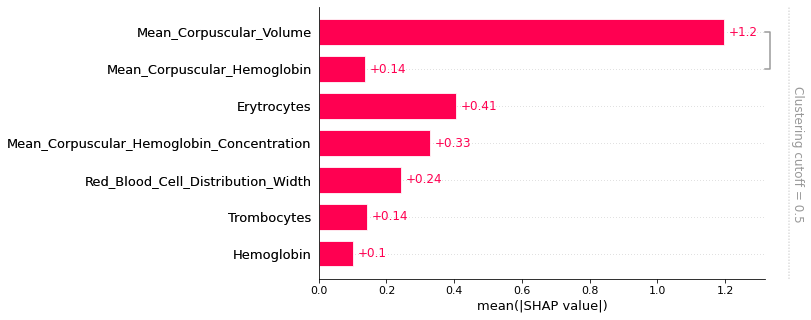

In [258]:
#test set
shap_values = explainer(med_test)
clustering = shap.utils.hclust(med_test, med_test_label) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values, clustering=clustering)

In [117]:
len(med_test)

2656

In [118]:
#validation set
#shap_values = explainer(X_test)
#clustering = shap.utils.hclust(X_test, y_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
#shap.plots.bar(shap_values, clustering=clustering)

In [119]:
# Feature importance in percentages (https://github.com/slundberg/shap/issues/274)
# Scale of the SHAP values has a linear relation (distance are equal from 2-3 and from 3-4)
# That results in values that represent the fraction of the model output variability attributable to each feature across the whole dataset.

In [136]:
abs(shap_values.values).sum(0)

array([3445.96529697,  646.51197318, 2372.91069544, 2916.16421855,
       1134.5192444 , 3269.05012583,   27.11894906])

In [137]:
fi_shap = abs(shap_values.values).sum(0)

In [138]:
fi_shap = fi_shap/fi_shap.sum()
fi_shap.sum(), fi_shap.shape, fi_shap

(1.0,
 (7,),
 array([0.24948634, 0.04680718, 0.17179767, 0.21112898, 0.08213868,
        0.23667776, 0.0019634 ]))

In [139]:
FI = np.column_stack([FEATURE_KEYS_test, fi_shap])

In [140]:
FI

array([['Mean_Corpuscular_Volume', '0.2494863375797134'],
       ['Red_Blood_Cell_Distribution_Width', '0.04680717607072764'],
       ['Mean_Corpuscular_Hemoglobin', '0.17179766706611346'],
       ['Hemoglobin', '0.21112897779512768'],
       ['Mean_Corpuscular_Hemoglobin_Concentration',
        '0.08213868301207823'],
       ['Erytrocytes', '0.23667775876179847'],
       ['Trombocytes', '0.0019633997144411016']], dtype='<U41')

In [141]:
FI_df = pd.DataFrame(FI, columns=['FEATURES', 'Importance'])

In [142]:
FI_df

,FEATURES,Importance
0,Mean_Corpuscular_Volume,0.2494863375797134
1,Red_Blood_Cell_Distribution_Width,0.04680717607072764
2,Mean_Corpuscular_Hemoglobin,0.17179766706611346
3,Hemoglobin,0.21112897779512768
4,Mean_Corpuscular_Hemoglobin_Concentration,0.08213868301207823
5,Erytrocytes,0.23667775876179847
6,Trombocytes,0.0019633997144411016


In [107]:
FI_df['Percentage'] = FI_df['Importance'].astype(float).apply(lambda x: 100 * x).values

In [108]:
FI_df['Percentage']

0    42.653558
1    11.077520
2     6.973899
3     4.776597
4    13.693410
5    14.254725
6     6.570291
Name: Percentage, dtype: float64

<a name='5-3'></a>
### 5.3 SHAP Local Feature Importance Plot
This plot is made of all the dots in the test data. It delivers the following information:

- **Feature importance**: Variables are ranked in descending order.
- **Impact**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- **Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- **Correlation**: A low level of “MCV” has a high and positive impact on being affected. The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

The issue with global feature importance is that prevalence is mixed with magnitude. This means that rare high magnitude effects will not appear in the feature importance plot. 


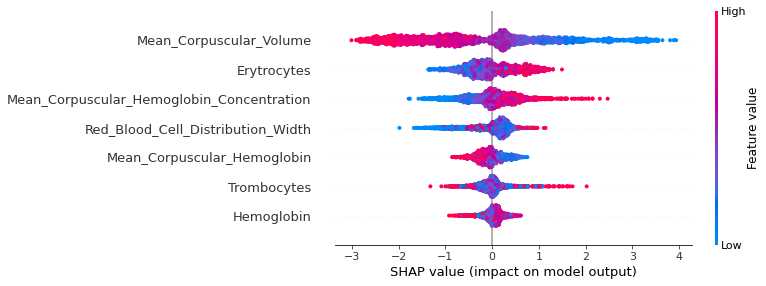

In [109]:
shap.plots.beeswarm(shap_values)

### 5.3.1 Interaction Plots
Features that may interact with MCV. 

For Beta Thal: 

The amount of MCV interacts with geslacht. A lower MCV is more predictive for testing positively on Beta Thalassemia, and higher MCV for testing negative. But this relationship is stronger for men than for women. Note: this is not a causal model. 

HB also interacts with MCV: A higher HB combined with a lower MCV is more predictive for testing positively on Betha Thal than a lower HB. And reverse is true for testing negatively.  

Ferritin: High ferritin combined with a low MCV seems to be more predictive for testing prositively on Beta Thalessemia, and high ferritin with high MCV seems to predictive for testing negatively than having a low ferritin.


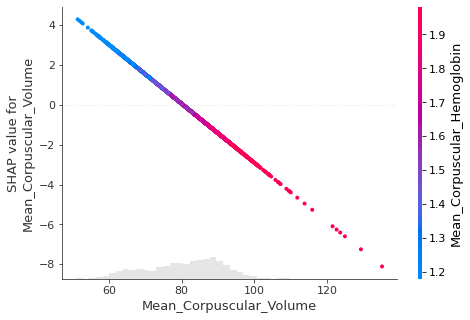

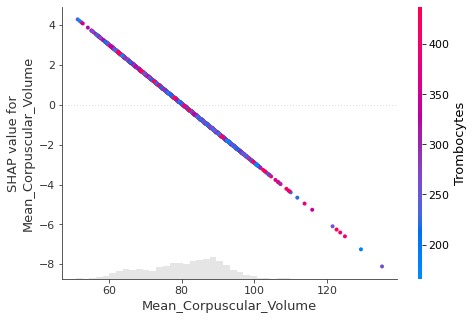

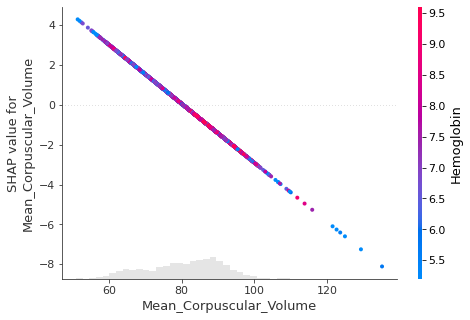

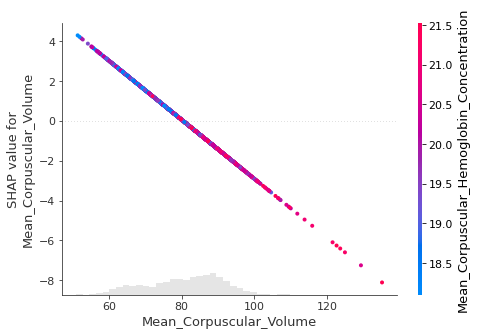

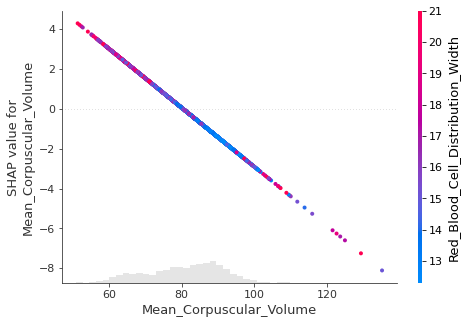

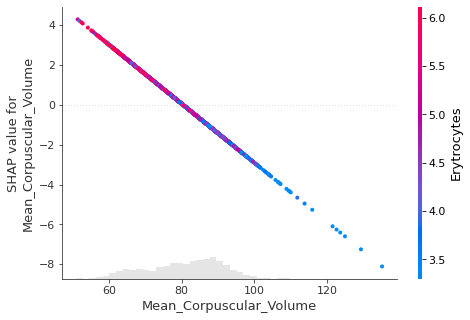

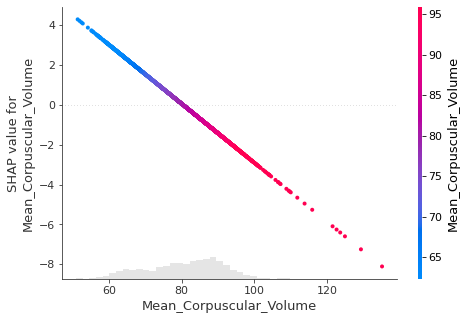

In [144]:
inds = shap.utils.potential_interactions(shap_values[:, "Mean_Corpuscular_Volume"], shap_values)

# Plots colored by each of the top three possible interacting features
for i in range(7):
    shap.plots.scatter(shap_values[:,"Mean_Corpuscular_Volume"], color=shap_values[:,inds[i]])

### 5.3.2 Plots to explain individual predictions
The plot below summarizes how much each feature contributes to the risk of testing positively on Alpha/Beta-Thalassemia for a particular patient. Features in red are shown to have a positive (increased) impact on the prediction, while those in blue are shown to have a negative (reduced) impact on the prediction. We can see that the amount of MCV in this case contributed to an decrease in the risk of testing positively on Beta-Thalassemia (by about 1.2).

Note: These relationships are not necessarily causal. Feature impact can be due to correlation.

In [113]:
feature_names = ['MCV', 'RDWCV', 'MCH', 'Hb', 'MCHC', 'RBC',  'Plt']

# Individualized Explanations for each Patient
shap.initjs()
shap_values = explainer.shap_values(med_test)
shap.force_plot(explainer.expected_value, shap_values[436,:], med_test.iloc[436,:], feature_names)

In [83]:
med_test[436:437]

,Mean_Corpuscular_Volume,Red_Blood_Cell_Distribution_Width,Mean_Corpuscular_Hemoglobin,Hemoglobin,Mean_Corpuscular_Hemoglobin_Concentration,Erytrocytes,Trombocytes
2560,83.7,16.8,1.578,6.2,18.8,3.93,243.0


In [82]:
med_test_label[436:437]

2560    0
Name: affected_model, dtype: int64

We can do the same for all patients in the test set (and cluster them)

## 6 - Get Predictions

In [235]:
predictions_ML = model.predict(xgb.DMatrix(med_test))
predictions_ML

array([0.21602495, 0.9312864 , 0.12899289, ..., 0.6434064 , 0.7157408 ,
       0.60701805], dtype=float32)

In [237]:
predictions_LR = logreg_model.predict_proba(med_test)[:, 1] 
len(predictions_LR)

ValueError: X has 9 features, but LogisticRegression is expecting 7 features as input.

In [236]:
med_test['LR_preds'] = predictions_LR
med_test['ML_preds'] = predictions_ML

In [244]:
Medlon_test_set = pd.concat([med_test, med_test_label], axis=1)
Medlon_test_set

,Mean_Corpuscular_Volume,Red_Blood_Cell_Distribution_Width,Mean_Corpuscular_Hemoglobin,Hemoglobin,Mean_Corpuscular_Hemoglobin_Concentration,Erytrocytes,Trombocytes,LR_preds,ML_preds,affected_model
2193,76.3,15.5,1.438,6.5,18.8,4.52,469.0,0.484838,0.216025,0
3078,76.0,14.6,1.580,8.5,20.8,5.38,228.0,0.771847,0.931286,1
2689,89.7,13.4,1.908,9.1,21.3,4.77,287.0,0.314621,0.128993,0
2577,83.3,13.6,1.624,7.0,19.5,4.31,199.0,0.357307,0.378802,0
1772,59.0,16.9,1.099,6.3,18.6,5.73,199.0,0.962595,0.989650,1
...,...,...,...,...,...,...,...,...,...,...
3662,69.9,17.9,1.239,4.4,17.7,3.55,514.0,0.404171,0.278315,1
4673,89.4,13.0,1.797,8.3,20.1,4.62,236.0,0.234532,0.115078,1
3050,72.6,21.0,1.418,6.0,19.5,4.23,472.0,0.509161,0.643406,1
3264,67.6,16.0,1.270,6.2,18.8,4.88,362.0,0.809138,0.715741,1


In [246]:
file_path = r"./Validation_data.xlsx"

with pd.ExcelWriter(file_path) as writer:  
    Medlon_test_set.to_excel(writer, sheet_name='Validation_data', index=False)